In [38]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
import os
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb
import math
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

os.environ['HTTP_PROXY'] = 'http://127.0.0.1:7890'
os.environ['HTTPS_PROXY'] = 'http://127.0.0.1:7890'


df = pd.read_csv('final_merged_data.csv', encoding='utf-8')

# 2. 将Date列转换为日期格式
df['Date'] = pd.to_datetime(df['Date'])

# 3. 设置Date列为索引（inplace=True 直接修改原数据）
df.set_index('Date', inplace=True)

# 4. 删除Unnamed: 0列（axis=1表示列，inplace=True 直接修改）
if 'Unnamed: 0' in df.columns:  # 先判断列是否存在，避免报错
    df.drop('Unnamed: 0', axis=1, inplace=True)

# 验证处理结果
print("数据处理完成！")
print(f"数据形状：{df.shape}")  # 输出行数和列数
print("\n数据前5行预览：")
print(df.head())
print("\n数据列名：")
print(df.columns.tolist())

数据处理完成！
数据形状：(2510, 12)

数据前5行预览：
           Ticker        Open        High         Low       Close    Volume  \
Date                                                                          
2023-12-26   AAPL  191.798670  192.076049  191.025969  191.243912  28919300   
2023-12-26   GOOG  141.915618  142.873446  141.439196  141.756821  11170100   
2023-12-26   META  352.527485  354.503701  350.998190  352.368591   9898600   
2023-12-26   MSFT  369.490977  371.402479  368.013013  369.155975  12673100   
2023-12-26   TSLA  254.490005  257.970001  252.910004  256.609985  86892400   

                                                   GSPC_Close  \
Date                                                            
2023-12-26  Ticker\n^GSPC    4774.75\nName: 2023-12-26 00:...   
2023-12-26  Ticker\n^GSPC    4774.75\nName: 2023-12-26 00:...   
2023-12-26  Ticker\n^GSPC    4774.75\nName: 2023-12-26 00:...   
2023-12-26  Ticker\n^GSPC    4774.75\nName: 2023-12-26 00:...   
2023-12-26  Ticker\n^G

In [39]:
import pandas as pd
import re
import numpy as np

def clean_market_column(text):
    """精准提取CSV中大盘列的纯数值，处理特殊格式文本"""
    if pd.isna(text) or not isinstance(text, str) or text.strip() == '':
        return np.nan
    # 匹配格式："Ticker\n^GSPC    4774.75\nName: ..." → 提取4774.75
    nums = re.findall(r'-?\d+\.?\d*', text.replace('\n', ' ').strip())
    if nums:
        try:
            return float(nums[0])
        except:
            return np.nan
    return np.nan

# ===================== 1. 读取数据（严格匹配你的CSV格式） =====================
# 读取时指定引号处理方式，避免文本列被拆分
df = pd.read_csv(
    'final_merged_data.csv',
    encoding='utf-8',
    sep=',',
    quotechar='"',  # 处理带双引号的文本列
    na_values=['', 'NaN', 'N/A'],
    keep_default_na=True
)

# 打印列名确认（验证GSPC_Close等列存在）
print("🔍 CSV真实列名：")
print(df.columns.tolist())
print("-"*60)

# ===================== 2. 基础数据处理 =====================
# 日期转换+去空
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df = df.dropna(subset=['Date'])  # 删除无有效日期的行

# 设置日期索引
df.set_index('Date', inplace=True)

# 删除Unnamed: 0列（仅当存在时）
if 'Unnamed: 0' in df.columns:
    df.drop('Unnamed: 0', axis=1, inplace=True)

# ===================== 3. 清洗大盘列（核心！） =====================
# 确认存在的大盘列（你的CSV明确包含这些列）
market_cols = ['GSPC_Close', 'GSPC_pct', 'GSPC_ma5', 'VIX_Close', 'VIX_pct', 'VIX_ma5']

# 逐个清洗大盘列
for col in market_cols:
    if col in df.columns:
        df[col] = df[col].apply(clean_market_column)
        print(f"✅ 已清洗列：{col}")

# ===================== 4. 数值转换+空值填充 =====================
# 核心数值列（个股+大盘）
core_cols = ['Open', 'High', 'Low', 'Close', 'Volume'] + market_cols
core_cols = [col for col in core_cols if col in df.columns]

# 强制转换为数值类型
for col in core_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# 金融数据专用填充：前向填充→后向填充→0兜底
df[core_cols] = df[core_cols].ffill().bfill().fillna(0)

# ===================== 5. 验证清洗结果 =====================
print("\n✅ 数据清洗完成！最终验证：")
print(f"📊 数据总行数：{len(df)}")
print(f"📋 大盘列数据类型：")
print(df[market_cols].dtypes)
print(f"\n🔍 清洗后前3行大盘数据：")
print(df[market_cols].head(3))
print(f"\n🚫 空值统计（核心列）：")
print(df[core_cols].isnull().sum())

🔍 CSV真实列名：
['Unnamed: 0', 'Date', 'Ticker', 'Open', 'High', 'Low', 'Close', 'Volume', 'GSPC_Close', 'GSPC_pct', 'GSPC_ma5', 'VIX_Close', 'VIX_pct', 'VIX_ma5']
------------------------------------------------------------
✅ 已清洗列：GSPC_Close
✅ 已清洗列：GSPC_pct
✅ 已清洗列：GSPC_ma5
✅ 已清洗列：VIX_Close
✅ 已清洗列：VIX_pct
✅ 已清洗列：VIX_ma5

✅ 数据清洗完成！最终验证：
📊 数据总行数：2510
📋 大盘列数据类型：
GSPC_Close    float64
GSPC_pct      float64
GSPC_ma5      float64
VIX_Close     float64
VIX_pct       float64
VIX_ma5       float64
dtype: object

🔍 清洗后前3行大盘数据：
            GSPC_Close  GSPC_pct     GSPC_ma5  VIX_Close  VIX_pct    VIX_ma5
Date                                                                        
2023-12-26     4774.75  0.004232  4758.709961      12.99 -0.00307  13.223333
2023-12-26     4774.75  0.004232  4758.709961      12.99 -0.00307  13.223333
2023-12-26     4774.75  0.004232  4758.709961      12.99 -0.00307  13.223333

🚫 空值统计（核心列）：
Open          0
High          0
Low           0
Close         0
Volume        0
GSP

In [40]:
import yfinance as yf
import pandas as pd
import numpy as np
import xgboost as xgb
import math
import re
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

# 新增：设置中文字体（可选，避免乱码）
plt.rcParams['font.sans-serif'] = ['DejaVu Sans', 'SimHei']
plt.rcParams['axes.unicode_minus'] = False

import os
os.environ['HTTP_PROXY'] = 'http://127.0.0.1:7890'
os.environ['HTTPS_PROXY'] = 'http://127.0.0.1:7890'

# ===================== 1. 数据清洗函数（保留） =====================
def clean_market_column(text):
    if pd.isna(text) or not isinstance(text, str) or text.strip() == '':
        return np.nan
    nums = re.findall(r'-?\d+\.?\d*', text.replace('\n', ' ').strip())
    if nums:
        try:
            return float(nums[0])
        except:
            return np.nan
    return np.nan

# ===================== 2. 数据加载与清洗（保留） =====================
df = pd.read_csv(
    'final_merged_data.csv',
    encoding='utf-8',
    sep=',',
    quotechar='"',
    na_values=['', 'NaN', 'N/A'],
    keep_default_na=True
)

df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df = df.dropna(subset=['Date'])
df.set_index('Date', inplace=True)
if 'Unnamed: 0' in df.columns:
    df.drop('Unnamed: 0', axis=1, inplace=True)

market_cols = ['GSPC_Close', 'GSPC_pct', 'GSPC_ma5', 'VIX_Close', 'VIX_pct', 'VIX_ma5']
for col in market_cols:
    if col in df.columns:
        df[col] = df[col].apply(clean_market_column)

core_cols = ['Open', 'High', 'Low', 'Close', 'Volume'] + market_cols
core_cols = [col for col in core_cols if col in df.columns]
for col in core_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')
df[core_cols] = df[core_cols].ffill().bfill().fillna(0)

# ===================== 3. 工具函数（保留+新增回测函数） =====================
def calculate_rsi(prices, window=14):
    delta = prices.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / (loss + 1e-8)
    rsi = 100 - (100 / (1 + rs))
    return rsi

# 新增：计算最大回撤（量化核心指标）
def calculate_max_drawdown(returns):
    cumulative = (1 + returns).cumprod()
    running_max = cumulative.cummax()
    drawdown = (cumulative / running_max) - 1
    return drawdown.min()

# 新增：虚拟交易回测函数
def backtest_strategy(df_ticker, y_pred_calibrated, initial_capital=10000):
    """
    多空策略回测：
    - df_ticker: 单只股票的DataFrame
    - y_pred_calibrated: 模型预测的5天总收益率数组
    - initial_capital: 初始资金
    """
    # 复制数据并对齐索引
    df_backtest = df_ticker.copy().reset_index()
    # 只保留有预测结果的行
    valid_len = min(len(df_backtest)-5, len(y_pred_calibrated))
    df_backtest = df_backtest.iloc[:valid_len+5]  # 包含t+5天的价格
    
    # 生成交易信号：1=做多，-1=做空，0=无仓位
    df_backtest['signal'] = 0
    df_backtest.loc[:valid_len-1, 'signal'] = np.where(y_pred_calibrated[:valid_len] > 0, 1, -1)
    
    # 计算每日收益率（5天持有期的日化收益）
    df_backtest['daily_return'] = 0.0
    for i in range(valid_len):
        # t日买入，t+5日卖出，计算5天总收益并日化
        if i+5 < len(df_backtest):
            total_return = (df_backtest.loc[i+5, 'Close'] / df_backtest.loc[i, 'Close']) - 1
            daily_return = (1 + total_return) ** (1/5) - 1  # 日化收益
            # 根据信号调整收益（做空为负）
            df_backtest.loc[i:i+4, 'daily_return'] = daily_return * df_backtest.loc[i, 'signal']
    
    # 计算资金曲线
    df_backtest['strategy_return'] = df_backtest['daily_return'].fillna(0)
    df_backtest['strategy_cumulative'] = initial_capital * (1 + df_backtest['strategy_return']).cumprod()
    
    # 计算买入持有策略（基准）
    df_backtest['buy_hold_return'] = df_backtest['Close'].pct_change().fillna(0)
    df_backtest['buy_hold_cumulative'] = initial_capital * (1 + df_backtest['buy_hold_return']).cumprod()
    
    # 计算核心指标
    total_days = len(df_backtest)
    annual_factor = 252 / total_days  # 年化因子（252个交易日）
    
    # 策略指标
    strategy_total_return = (df_backtest['strategy_cumulative'].iloc[-1] / initial_capital) - 1
    strategy_annual_return = (1 + strategy_total_return) ** annual_factor - 1
    strategy_max_dd = calculate_max_drawdown(df_backtest['strategy_return'])
    
    # 基准指标
    buy_hold_total_return = (df_backtest['buy_hold_cumulative'].iloc[-1] / initial_capital) - 1
    buy_hold_annual_return = (1 + buy_hold_total_return) ** annual_factor - 1
    buy_hold_max_dd = calculate_max_drawdown(df_backtest['buy_hold_return'])
    
    return {
        'df_backtest': df_backtest,
        'strategy_total_return': strategy_total_return,
        'strategy_annual_return': strategy_annual_return,
        'strategy_max_dd': strategy_max_dd,
        'buy_hold_total_return': buy_hold_total_return,
        'buy_hold_annual_return': buy_hold_annual_return,
        'buy_hold_max_dd': buy_hold_max_dd
    }

# ===================== 4. 核心训练函数（新增回测调用） =====================
def xgb_train_optimized(df, ticker):
    df = df.copy()
    
    required_cols = ['Close', 'GSPC_pct']
    missing_cols = [col for col in required_cols if col not in df.columns]
    if missing_cols or len(df) < 100:
        print(f'❌ 【{ticker}】数据不足/缺失关键列（缺失：{missing_cols}），跳过')
        return None
    
    # 特征工程（保留所有α特征）
    df['ma20'] = df['Close'].shift(1).rolling(20, min_periods=20).mean()
    df['ma5'] = df['Close'].shift(1).rolling(5, min_periods=5).mean()
    df['volatility_7d'] = df['Close'].shift(1).rolling(7).std()
    df['rsi_14d'] = calculate_rsi(df['Close'], 14)
    df['price_ma5_ratio'] = df['Close'].shift(1) / df['ma5']
    
    df['stock_pct'] = df['Close'].pct_change(1)
    df['alpha_pct'] = df['stock_pct'] - df['GSPC_pct']
    
    def calculate_residual_pct(stock_pct, gspc_pct, window=20):
        residuals = np.zeros_like(stock_pct)
        residuals[:window-1] = np.nan
        for i in range(window-1, len(stock_pct)):
            X = gspc_pct.iloc[i-window+1:i+1].values.reshape(-1, 1)
            y = stock_pct.iloc[i-window+1:i+1].values
            if np.isnan(X).any() or np.isnan(y).any() or len(X) < window:
                residuals[i] = np.nan
                continue
            lr = LinearRegression()
            lr.fit(X, y)
            y_pred = lr.predict(X)
            residuals[i] = y[-1] - y_pred[-1]
        return pd.Series(residuals, index=stock_pct.index)
    
    df['residual_alpha_pct'] = calculate_residual_pct(df['stock_pct'], df['GSPC_pct'])
    df['stock_vol_7d'] = df['stock_pct'].rolling(7).std()
    df['gspc_vol_7d'] = df['GSPC_pct'].rolling(7).std()
    df['vol_ratio'] = df['stock_vol_7d'] / (df['gspc_vol_7d'] + 0.0001)
    df['beta_20d'] = df['stock_pct'].rolling(20).cov(df['GSPC_pct']) / df['GSPC_pct'].rolling(20).var()
    
    # 目标变量：未来5天总收益率（无泄露）
    df['Close_t5'] = df['Close'].shift(-5)
    df['Target_Return_5d'] = (df['Close_t5'] / df['Close']) - 1
    df = df.dropna(subset=['Target_Return_5d'])
    df = df.dropna()
    if len(df) < 80:
        print(f'❌ 【{ticker}】特征生成后数据不足，跳过')
        return None
    
    FEATURES = [
        'ma5', 'rsi_14d', 'volatility_7d', 'price_ma5_ratio',
        'alpha_pct', 'residual_alpha_pct', 'vol_ratio', 'beta_20d'
    ]
    
    # 滚动回测
    train_window = 90
    test_window = 10   
    step = 10          
    
    all_y_test = []          
    all_y_pred_calibrated = []
    all_test_close = []      
    all_test_stock_pct = []   
    all_test_gspc_pct = []    
    all_test_alpha_pct = []   
    
    max_start = len(df) - train_window - test_window
    if max_start <= 0:
        print(f'❌ 【{ticker}】数据量不足以支撑滚动回测，跳过')
        return None
    
    for start in range(0, max_start, step):
        train_end = start + train_window
        test_end = train_end + test_window
        
        train = df.iloc[start:train_end]
        test = df.iloc[train_end:test_end]
        
        if len(test) < test_window:
            break
        
        X_train, y_train = train[FEATURES], train['Target_Return_5d']
        X_test, y_test = test[FEATURES], test['Target_Return_5d']
        
        model = xgb.XGBRegressor(
            n_estimators=120,         
            learning_rate=0.04,       
            max_depth=4,              
            subsample=0.85,            
            colsample_bytree=0.85,     
            reg_alpha=0.02,          
            reg_lambda=0.08,           
            random_state=42,
            objective='reg:squarederror',
            eval_metric='rmse'
        )
        model.fit(X_train, y_train)
        
        y_pred = model.predict(X_test)
        pred_mean = y_pred.mean()
        true_mean = y_test.mean()
        y_pred_calibrated = y_pred - pred_mean + true_mean
        
        # 存储结果
        all_y_test.extend(y_test.values)
        all_y_pred_calibrated.extend(y_pred_calibrated)
        all_test_close.extend(test['Close'].values)
        all_test_stock_pct.extend(test['stock_pct'].values)
        all_test_gspc_pct.extend(test['GSPC_pct'].values)
        all_test_alpha_pct.extend(test['alpha_pct'].values)
    
    # 结果处理
    all_y_test = np.array(all_y_test)
    all_y_pred_calibrated = np.array(all_y_pred_calibrated)
    all_test_close = np.array(all_test_close)
    all_test_stock_pct = np.array(all_test_stock_pct)
    all_test_gspc_pct = np.array(all_test_gspc_pct)
    
    valid_mask = ~(np.isnan(all_y_test) | np.isnan(all_y_pred_calibrated) | np.isnan(all_test_close))
    all_y_test = all_y_test[valid_mask]
    all_y_pred_calibrated = all_y_pred_calibrated[valid_mask]
    all_test_close = all_test_close[valid_mask]
    all_test_stock_pct = all_test_stock_pct[valid_mask]
    all_test_gspc_pct = all_test_gspc_pct[valid_mask]
    
    if len(all_y_test) < 10:
        print(f'❌ 【{ticker}】有效回测数据不足，跳过')
        return None
    
    # 1. 收益率指标
    pct_mse_optimized = mean_squared_error(all_y_test, all_y_pred_calibrated)
    pct_r2 = r2_score(all_y_test, all_y_pred_calibrated)
    
    # 涨跌方向准确率计算
    actual_direction = np.where(all_y_test > 0, 1, 0)
    pred_direction = np.where(all_y_pred_calibrated > 0, 1, 0)
    correct_predictions = np.sum(actual_direction == pred_direction)
    total_predictions = len(actual_direction)
    direction_accuracy = correct_predictions / total_predictions * 100
    
    # 2. 股价指标（适配5天预测）
    common_len = min(len(all_test_close)-5, len(all_y_pred_calibrated))
    if common_len < 5:
        print(f'❌ 【{ticker}】股价评估数据不足，跳过')
        return None
    
    y_true_price = all_test_close[5:common_len+5]
    y_naive_price = all_test_close[:common_len]
    y_xgb_price = all_test_close[:common_len] * (1 + all_y_pred_calibrated[:common_len])
    y_mean_return = np.mean(all_y_test[:common_len])
    y_mean_price = all_test_close[:common_len] * (1 + y_mean_return)
    
    RMSE_naive = math.sqrt(mean_squared_error(y_true_price, y_naive_price))
    RMSE_mean = math.sqrt(mean_squared_error(y_true_price, y_mean_price))
    RMSE_xgb = math.sqrt(mean_squared_error(y_true_price, y_xgb_price))
    
    # ===================== 🔥 新增：调用虚拟交易回测 =====================
    backtest_result = backtest_strategy(df, all_y_pred_calibrated)
    
    # 输出结果（新增回测指标）
    print(f'\n✅ 【{ticker}】优化版回测结果（未来5天总收益率预测）')
    print(f'   5天总收益MSE: {pct_mse_optimized:.6f} | R²: {pct_r2:.4f}')
    print(f'   🎯 涨跌方向准确率: {direction_accuracy:.2f}% ({correct_predictions}/{total_predictions})')
    print(f"\n📈 【{ticker}】虚拟交易回测结果")
    print(f'   📊 策略总收益: {backtest_result["strategy_total_return"]:.2%} | 年化收益: {backtest_result["strategy_annual_return"]:.2%}')
    print(f'   📊 买入持有总收益: {backtest_result["buy_hold_total_return"]:.2%} | 年化收益: {backtest_result["buy_hold_annual_return"]:.2%}')
    print(f'   🚨 策略最大回撤: {backtest_result["strategy_max_dd"]:.2%} | 基准最大回撤: {backtest_result["buy_hold_max_dd"]:.2%}')
    print(f"\n📌 【{ticker}】基准对比（预测5天后价格）")
    print(f"   傻瓜模型RMSE: {RMSE_naive:.2f} USD")
    print(f"   均值模型RMSE: {RMSE_mean:.2f} USD")
    print(f"   XGBoost模型RMSE: {RMSE_xgb:.2f} USD")
    
    is_beat_naive = RMSE_xgb < RMSE_naive
    is_beat_mean = RMSE_xgb < RMSE_mean
    beat_naive_ratio = (RMSE_naive - RMSE_xgb) / RMSE_naive * 100 if RMSE_naive !=0 else 0
    beat_mean_ratio = (RMSE_mean - RMSE_xgb) / RMSE_mean * 100 if RMSE_mean !=0 else 0
    
    if is_beat_naive and is_beat_mean:
        print(f"   ✅ 同时打败两个基准！对比傻瓜模型误差降低 {beat_naive_ratio:.1f}%，对比均值模型误差降低 {beat_mean_ratio:.1f}%")
    elif is_beat_naive and not is_beat_mean:
        print(f"   ⚠️ 仅打败傻瓜模型（误差降低 {beat_naive_ratio:.1f}%），未打败均值模型")
    elif not is_beat_naive and is_beat_mean:
        print(f"   ⚠️ 仅打败均值模型（误差降低 {beat_mean_ratio:.1f}%），未打败傻瓜模型")
    else:
        print(f"   ❌ 未打败任何基准")
    
    # 返回结果（新增回测数据）
    return {
        'y_test_pct': all_y_test,
        'y_pred_pct_calibrated': all_y_pred_calibrated,
        'y_test_price': y_true_price,
        'y_pred_price': y_xgb_price,
        'test_close': all_test_close,
        'pct_mse_optimized': pct_mse_optimized,
        'pct_r2': pct_r2,
        'direction_accuracy': direction_accuracy,
        'correct_predictions': correct_predictions,
        'total_predictions': total_predictions,
        'RMSE_naive': RMSE_naive,
        'RMSE_mean': RMSE_mean,
        'RMSE_xgb': RMSE_xgb,
        # 新增回测结果
        'backtest_result': backtest_result
    }




✅ 【AAPL】优化版回测结果（未来5天总收益率预测）
   5天总收益MSE: 0.001063 | R²: 0.4280
   🎯 涨跌方向准确率: 71.84% (273/380)

📈 【AAPL】虚拟交易回测结果
   📊 策略总收益: 6.41% | 年化收益: 4.15%
   📊 买入持有总收益: 14.15% | 年化收益: 9.05%
   🚨 策略最大回撤: -22.06% | 基准最大回撤: -33.36%

📌 【AAPL】基准对比（预测5天后价格）
   傻瓜模型RMSE: 9.53 USD
   均值模型RMSE: 9.48 USD
   XGBoost模型RMSE: 7.18 USD
   ✅ 同时打败两个基准！对比傻瓜模型误差降低 24.6%，对比均值模型误差降低 24.3%

✅ 【GOOG】优化版回测结果（未来5天总收益率预测）
   5天总收益MSE: 0.001173 | R²: 0.3436
   🎯 涨跌方向准确率: 73.95% (281/380)

📈 【GOOG】虚拟交易回测结果
   📊 策略总收益: -3.65% | 年化收益: -2.41%
   📊 买入持有总收益: 29.17% | 年化收益: 18.24%
   🚨 策略最大回撤: -22.49% | 基准最大回撤: -29.35%

📌 【GOOG】基准对比（预测5天后价格）
   傻瓜模型RMSE: 8.65 USD
   均值模型RMSE: 8.37 USD
   XGBoost模型RMSE: 6.72 USD
   ✅ 同时打败两个基准！对比傻瓜模型误差降低 22.4%，对比均值模型误差降低 19.8%

✅ 【META】优化版回测结果（未来5天总收益率预测）
   5天总收益MSE: 0.001447 | R²: 0.3646
   🎯 涨跌方向准确率: 71.84% (273/380)

📈 【META】虚拟交易回测结果
   📊 策略总收益: 43.67% | 年化收益: 26.77%
   📊 买入持有总收益: 94.82% | 年化收益: 54.73%
   🚨 策略最大回撤: -17.77% | 基准最大回撤: -34.15%

📌 【META】基准对比（预测5天后价格）
   傻瓜模型RMSE: 29.72 USD
   均值模型

C:\Users\86176\AppData\Local\Temp\ipykernel_27312\630689758.py:58: UserWarning: Glyph 36164 (\N{CJK UNIFIED IDEOGRAPH-8D44}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\86176\AppData\Local\Temp\ipykernel_27312\630689758.py:58: UserWarning: Glyph 37329 (\N{CJK UNIFIED IDEOGRAPH-91D1}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\86176\AppData\Local\Temp\ipykernel_27312\630689758.py:58: UserWarning: Glyph 26354 (\N{CJK UNIFIED IDEOGRAPH-66F2}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\86176\AppData\Local\Temp\ipykernel_27312\630689758.py:58: UserWarning: Glyph 32447 (\N{CJK UNIFIED IDEOGRAPH-7EBF}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\86176\AppData\Local\Temp\ipykernel_27312\630689758.py:58: UserWarning: Glyph 23545 (\N{CJK UNIFIED IDEOGRAPH-5BF9}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\86176\AppData\Local\Temp\ipykernel_27312\630689758.py:58: UserWarning: Glyph 27604 (\N{CJK 

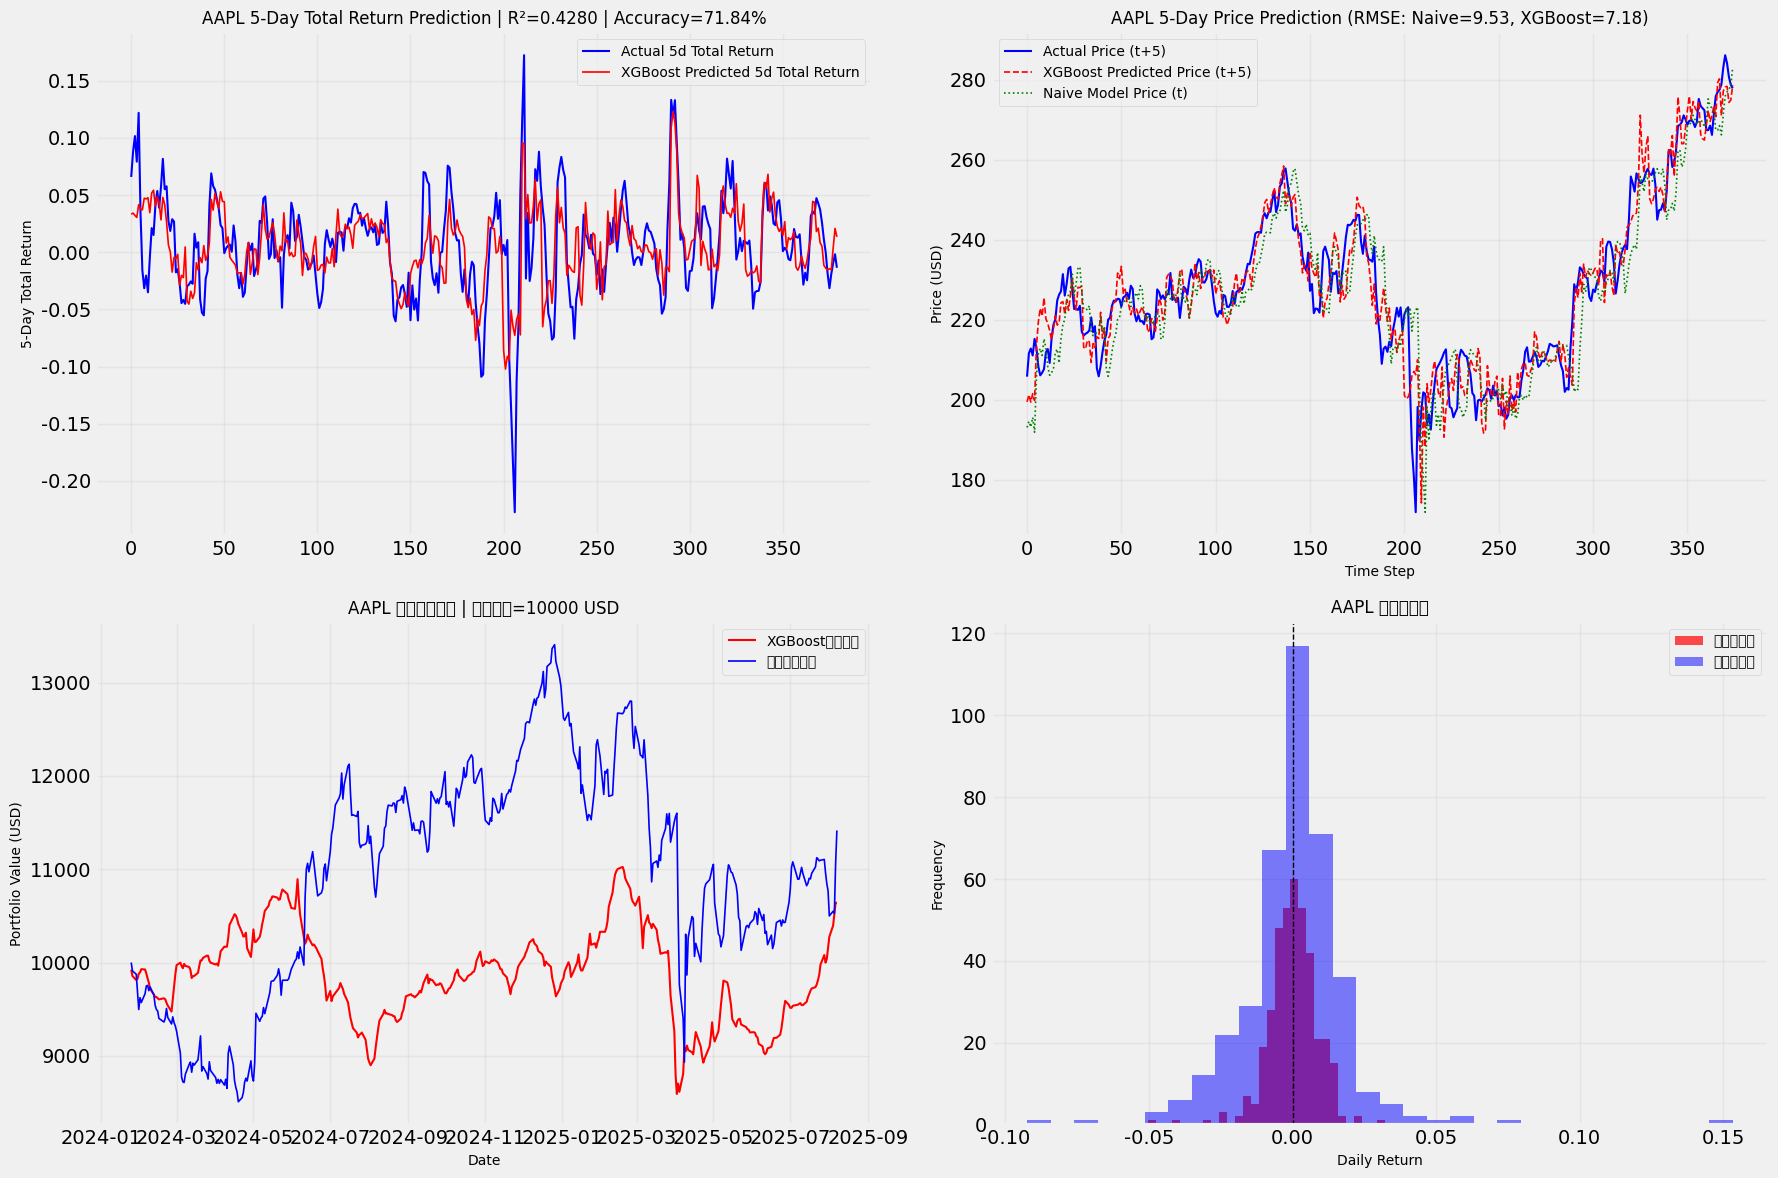


📊 优化版回测结果汇总（未来5天总收益率预测）：

📈 【AAPL】
  ├─ 5天总收益R²：0.4280 | MSE：0.001063
  ├─ 🎯 涨跌准确率：71.84% (273/380)
  ├─ 📊 策略收益：6.41% | 基准收益：14.15%
  ├─ 🚨 策略最大回撤：-22.06% | 基准最大回撤：-33.36%
  ├─ RMSE对比（USD）：傻瓜模型 9.53 | 均值模型 9.48 | XGBoost 7.18
  └─ 打败基准：傻瓜模型 ✅ | 均值模型 ✅
     --------------------------------------------------

📈 【GOOG】
  ├─ 5天总收益R²：0.3436 | MSE：0.001173
  ├─ 🎯 涨跌准确率：73.95% (281/380)
  ├─ 📊 策略收益：-3.65% | 基准收益：29.17%
  ├─ 🚨 策略最大回撤：-22.49% | 基准最大回撤：-29.35%
  ├─ RMSE对比（USD）：傻瓜模型 8.65 | 均值模型 8.37 | XGBoost 6.72
  └─ 打败基准：傻瓜模型 ✅ | 均值模型 ✅
     --------------------------------------------------

📈 【META】
  ├─ 5天总收益R²：0.3646 | MSE：0.001447
  ├─ 🎯 涨跌准确率：71.84% (273/380)
  ├─ 📊 策略收益：43.67% | 基准收益：94.82%
  ├─ 🚨 策略最大回撤：-17.77% | 基准最大回撤：-34.15%
  ├─ RMSE对比（USD）：傻瓜模型 29.72 | 均值模型 29.75 | XGBoost 23.06
  └─ 打败基准：傻瓜模型 ✅ | 均值模型 ✅
     --------------------------------------------------

📈 【MSFT】
  ├─ 5天总收益R²：0.4230 | MSE：0.000588
  ├─ 🎯 涨跌准确率：76.58% (291/380)
  ├─ 📊 策略收益：1.06% | 基准收益：30.10%
  ├─ 🚨 策略最大回撤：-1

In [41]:
# ===================== 5. 运行回测+可视化（新增资金曲线） =====================
stock_results_optimized = {}
for ticker, single_stock_df in df.groupby('Ticker'):
    stock_results_optimized[ticker] = xgb_train_optimized(single_stock_df, ticker)

# 可视化AAPL结果（新增资金曲线）
plt.rcParams['font.sans-serif'] = ['DejaVu Sans']
if 'AAPL' in stock_results_optimized and stock_results_optimized['AAPL'] is not None:
    res = stock_results_optimized['AAPL']
    backtest_res = res['backtest_result']
    df_backtest = backtest_res['df_backtest']
    
    # 创建2行2列的画布
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(18, 12))
    
    # 子图1：5天总收益对比
    valid_len = min(len(res['y_test_pct']), len(res['y_pred_pct_calibrated']))
    x_axis = range(valid_len)
    ax1.plot(x_axis, res['y_test_pct'][:valid_len], label='Actual 5d Total Return', color='blue', linewidth=1.5)
    ax1.plot(x_axis, res['y_pred_pct_calibrated'][:valid_len], label='XGBoost Predicted 5d Total Return', color='red', linewidth=1.2)
    ax1.set_title(f'AAPL 5-Day Total Return Prediction | R²={res["pct_r2"]:.4f} | Accuracy={res["direction_accuracy"]:.2f}%', fontsize=12)
    ax1.set_ylabel('5-Day Total Return', fontsize=10)
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 子图2：股价对比
    price_len = min(len(res['y_test_price']), len(res['y_pred_price']))
    if price_len > 0:
        x_axis_price = range(price_len)
        ax2.plot(x_axis_price, res['y_test_price'][:price_len], label='Actual Price (t+5)', color='blue', linewidth=1.5)
        ax2.plot(x_axis_price, res['y_pred_price'][:price_len], label='XGBoost Predicted Price (t+5)', color='red', linestyle='--', linewidth=1.2)
        ax2.plot(x_axis_price, res['test_close'][:price_len], label='Naive Model Price (t)', color='green', linestyle=':', linewidth=1.2)
        ax2.set_title(f'AAPL 5-Day Price Prediction (RMSE: Naive={res["RMSE_naive"]:.2f}, XGBoost={res["RMSE_xgb"]:.2f})', fontsize=12)
        ax2.set_xlabel('Time Step', fontsize=10)
        ax2.set_ylabel('Price (USD)', fontsize=10)
        ax2.legend()
        ax2.grid(True, alpha=0.3)
    
    # 子图3：资金曲线（核心）
    ax3.plot(df_backtest['Date'], df_backtest['strategy_cumulative'], label='XGBoost多空策略', color='red', linewidth=1.5)
    ax3.plot(df_backtest['Date'], df_backtest['buy_hold_cumulative'], label='买入持有基准', color='blue', linewidth=1.2)
    ax3.set_title(f'AAPL 资金曲线对比 | 初始资金=10000 USD', fontsize=12)
    ax3.set_xlabel('Date', fontsize=10)
    ax3.set_ylabel('Portfolio Value (USD)', fontsize=10)
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # 子图4：每日收益分布
    ax4.hist(df_backtest['strategy_return'], bins=30, alpha=0.7, label='策略日收益', color='red')
    ax4.hist(df_backtest['buy_hold_return'], bins=30, alpha=0.5, label='基准日收益', color='blue')
    ax4.axvline(0, color='black', linestyle='--', linewidth=1)
    ax4.set_title(f'AAPL 日收益分布', fontsize=12)
    ax4.set_xlabel('Daily Return', fontsize=10)
    ax4.set_ylabel('Frequency', fontsize=10)
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# ===================== 6. 汇总结果（新增回测统计） =====================
print("\n" + "="*80)
print("📊 优化版回测结果汇总（未来5天总收益率预测）：")
print("="*80)

total_tickers = len([k for k, v in stock_results_optimized.items() if v is not None])
beat_naive_count = 0
beat_mean_count = 0
avg_accuracy = 0.0
avg_strategy_return = 0.0  # 新增平均策略收益
avg_buy_hold_return = 0.0  # 新增平均基准收益

for ticker, res in stock_results_optimized.items():
    if res is None:
        continue
    
    beat_naive = res['RMSE_xgb'] < res['RMSE_naive']
    beat_mean = res['RMSE_xgb'] < res['RMSE_mean']
    
    if beat_naive: beat_naive_count += 1
    if beat_mean: beat_mean_count += 1
    avg_accuracy += res['direction_accuracy']
    avg_strategy_return += res['backtest_result']['strategy_total_return']
    avg_buy_hold_return += res['backtest_result']['buy_hold_total_return']
    
    print(f"\n📈 【{ticker}】")
    print(f"  ├─ 5天总收益R²：{res['pct_r2']:.4f} | MSE：{res['pct_mse_optimized']:.6f}")
    print(f"  ├─ 🎯 涨跌准确率：{res['direction_accuracy']:.2f}% ({res['correct_predictions']}/{res['total_predictions']})")
    print(f"  ├─ 📊 策略收益：{res['backtest_result']['strategy_total_return']:.2%} | 基准收益：{res['backtest_result']['buy_hold_total_return']:.2%}")
    print(f"  ├─ 🚨 策略最大回撤：{res['backtest_result']['strategy_max_dd']:.2%} | 基准最大回撤：{res['backtest_result']['buy_hold_max_dd']:.2%}")
    print(f"  ├─ RMSE对比（USD）：傻瓜模型 {res['RMSE_naive']:.2f} | 均值模型 {res['RMSE_mean']:.2f} | XGBoost {res['RMSE_xgb']:.2f}")
    print(f"  └─ 打败基准：傻瓜模型 {'✅' if beat_naive else '❌'} | 均值模型 {'✅' if beat_mean else '❌'}")
    print(f"     {'-'*50}")

if total_tickers > 0:
    avg_accuracy = avg_accuracy / total_tickers
    avg_strategy_return = avg_strategy_return / total_tickers
    avg_buy_hold_return = avg_buy_hold_return / total_tickers
    print(f"\n📋 整体统计：")
    print(f"  - 有效回测股票数：{total_tickers}")
    print(f"  - 平均涨跌准确率：{avg_accuracy:.2f}%")
    print(f"  - 平均策略总收益：{avg_strategy_return:.2%} | 平均基准总收益：{avg_buy_hold_return:.2%}")
    print(f"  - 打败傻瓜模型：{beat_naive_count}/{total_tickers} ({beat_naive_count/total_tickers*100:.1f}%)")
    print(f"  - 打败均值模型：{beat_mean_count}/{total_tickers} ({beat_mean_count/total_tickers*100:.1f}%)")
else:
    print("\n📋 整体统计：无有效回测结果")